In [1]:
# model_training_dl.ipynb

# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import ta  # Technical Analysis library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
# List of top 10 stocks (example: you can replace with your own list of top stocks)
top_10_stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'BRK-B', 'V', 'JNJ']

# Function to fetch data for each stock
def fetch_and_preprocess_data(tickers, start_date="2000-01-01", end_date="2023-12-31"):
    all_data = []

    for ticker in tickers:
        # Fetch stock data from Yahoo Finance
        data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
        
        # Compute technical indicators
        close_prices = data['Close'].squeeze()
        data['MACD'] = ta.trend.macd(close_prices)
        data['MACD_signal'] = ta.trend.macd_signal(close_prices)
        data['RSI'] = ta.momentum.rsi(close_prices)

        # Manually calculate VWAP
        typical_price = (data['High'] + data['Low'] + data['Close']) / 3
        data['VWAP'] = (typical_price * data['Volume']).cumsum() / data['Volume'].cumsum()

        # Add a new column for stock ticker
        data['Ticker'] = ticker

        # Calculate the target variable (buy=1, sell=0)
        data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)  # 1 for buy, 0 for sell
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Append the data for this stock to the all_data list
        all_data.append(data)

    # Concatenate data for all stocks
    all_data_df = pd.concat(all_data)

    return all_data_df

# Fetch and preprocess data for the top 10 stocks
stock_data = fetch_and_preprocess_data(top_10_stocks)

# Checking the shape and a preview of the data
print(stock_data.shape)
stock_data.head()

# Example output
# This will print the data with columns ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MACD', 'MACD_signal', 'RSI', 'VWAP', 'Ticker', 'Target']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

(51064, 56)


Price,Close,High,Low,Open,Volume,MACD,MACD_signal,RSI,VWAP,Ticker,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,V,V,V,V,V,JNJ,JNJ,JNJ,JNJ,JNJ
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-18,0.837899,0.868967,0.835074,0.863318,233441600.0,0.016703,0.014232,51.598956,0.797436,AAPL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-22,0.857198,0.880735,0.803535,0.829425,422296000.0,0.016474,0.014680,54.248081,0.798598,AAPL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-23,0.875556,0.896269,0.836015,0.852844,473099200.0,0.017571,0.015258,56.677076,0.800400,AAPL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-24,0.867672,0.897210,0.841664,0.883559,376432000.0,0.017601,0.015727,55.318665,0.801762,AAPL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-25,0.831308,0.881206,0.829425,0.864730,249144000.0,0.014523,0.015486,49.434067,0.802353,AAPL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
stock_data.shape

(51064, 56)

In [35]:
# Features and target
features = ['MACD', 'MACD_signal', 'RSI', 'VWAP']
X = stock_data[features]
y = stock_data['Target']

In [36]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
# Building a Deep Learning model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))  # Regularization to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification (Buy or Sell)

e:\AlgoTreade\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Early stopping to prevent overfitting and unnecessary training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [41]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5024 - loss: 0.6973 - val_accuracy: 0.5115 - val_loss: 0.6939
Epoch 2/50
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5139 - loss: 0.6938 - val_accuracy: 0.5071 - val_loss: 0.6936
Epoch 3/50
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5176 - loss: 0.6930 - val_accuracy: 0.5109 - val_loss: 0.6925
Epoch 4/50
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5109 - loss: 0.6930 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 5/50
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5149 - loss: 0.6924 - val_accuracy: 0.5103 - val_loss: 0.6930
Epoch 6/50
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5154 - loss: 0.6926 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 7/50
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5133 - loss: 0.6927 - val_accuracy: 0.5067 - val_loss: 0.6930
Epoch 8/50
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5187 - loss: 0.6922 - 

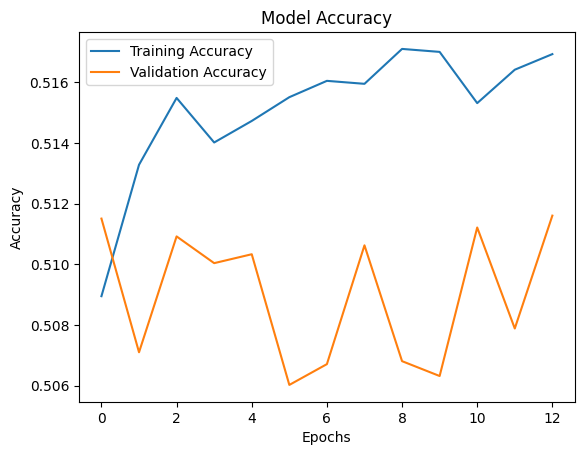

In [42]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5044 - loss: 0.6933
Test Accuracy: 0.5109


In [44]:
# Model predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [45]:
# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[  68 4921]
 [  74 5150]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.01      0.03      4989
           1       0.51      0.99      0.67      5224

    accuracy                           0.51     10213
   macro avg       0.50      0.50      0.35     10213
weighted avg       0.50      0.51      0.36     10213



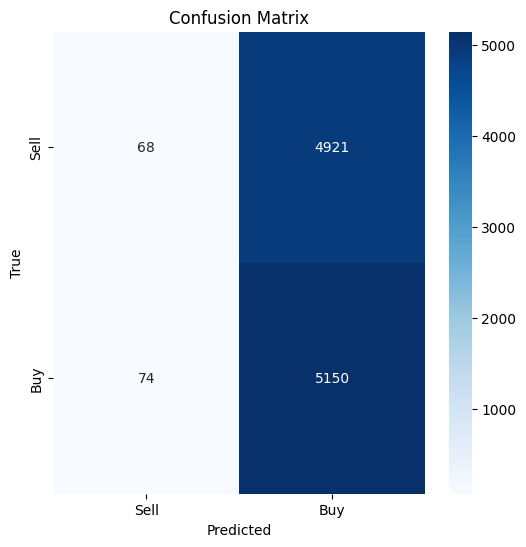

In [46]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Sell", "Buy"], yticklabels=["Sell", "Buy"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [47]:
from sklearn.preprocessing import StandardScaler

# Standardize the technical indicators
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets (time-series split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (40851, 4)
Testing data shape: (10213, 4)


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize RandomForestClassifier
rf = RandomForestClassifier()

# Define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.15      0.23      4891
           1       0.52      0.86      0.65      5322

    accuracy                           0.52     10213
   macro avg       0.51      0.50      0.44     10213
weighted avg       0.51      0.52      0.45     10213

[[ 727 4164]
 [ 744 4578]]


In [50]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Reshape X to be 3D (samples, time_steps, features)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
model.fit(X_scaled, y, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(X_scaled)

Epoch 1/10


e:\AlgoTreade\env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1277/1277 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4999 - loss: 0.6935 - val_accuracy: 0.5211 - val_loss: 0.6921
Epoch 2/10
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5138 - loss: 0.6932 - val_accuracy: 0.5214 - val_loss: 0.6923
Epoch 3/10
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5117 - loss: 0.6931 - val_accuracy: 0.5211 - val_loss: 0.6921
Epoch 4/10
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5191 - loss: 0.6925 - val_accuracy: 0.5164 - val_loss: 0.6924
Epoch 5/10
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5119 - loss: 0.6931 - val_accuracy: 0.5211 - val_loss: 0.6922
Epoch 6/10
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5127 - loss: 0.6928 - val_accuracy: 0.5215 - val_loss: 0.6925
Epoch 7/10
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5126 - loss: 0.6928 - val_accuracy: 0.5159 - val_loss: 0.6924
Epoch 8/10
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5132 - loss: 0.6929 - val_accurac

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model performance
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.5060217370018604
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      4891
           1       0.53      0.51      0.52      5322

    accuracy                           0.51     10213
   macro avg       0.51      0.51      0.51     10213
weighted avg       0.51      0.51      0.51     10213



In [52]:
import xgboost as xgb
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model performance
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.5088612552629003
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      4891
           1       0.53      0.52      0.53      5322

    accuracy                           0.51     10213
   macro avg       0.51      0.51      0.51     10213
weighted avg       0.51      0.51      0.51     10213



e:\AlgoTreade\env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:16:49] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [53]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix for Random Forest
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Confusion Matrix for XGBoost
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


Random Forest Confusion Matrix:
[[2438 2453]
 [2592 2730]]
XGBoost Confusion Matrix:
[[2419 2472]
 [2544 2778]]


In [54]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, verbose=2, n_jobs=-1)

# Fit grid search
grid_search_rf.fit(X_train, y_train)

# Best parameters found
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")

# Evaluate the best model
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print(f"Optimized Random Forest Accuracy: {accuracy_score(y_test, y_pred_best_rf)}")
print(classification_report(y_test, y_pred_best_rf))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Optimized Random Forest Accuracy: 0.5126799177518848
              precision    recall  f1-score   support

           0       0.49      0.38      0.43      4891
           1       0.53      0.64      0.58      5322

    accuracy                           0.51     10213
   macro avg       0.51      0.51      0.50     10213
weighted avg       0.51      0.51      0.50     10213



In [55]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 52.14%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00      4891
           1       0.52      1.00      0.69      5322

    accuracy                           0.52     10213
   macro avg       0.76      0.50      0.34     10213
weighted avg       0.75      0.52      0.36     10213



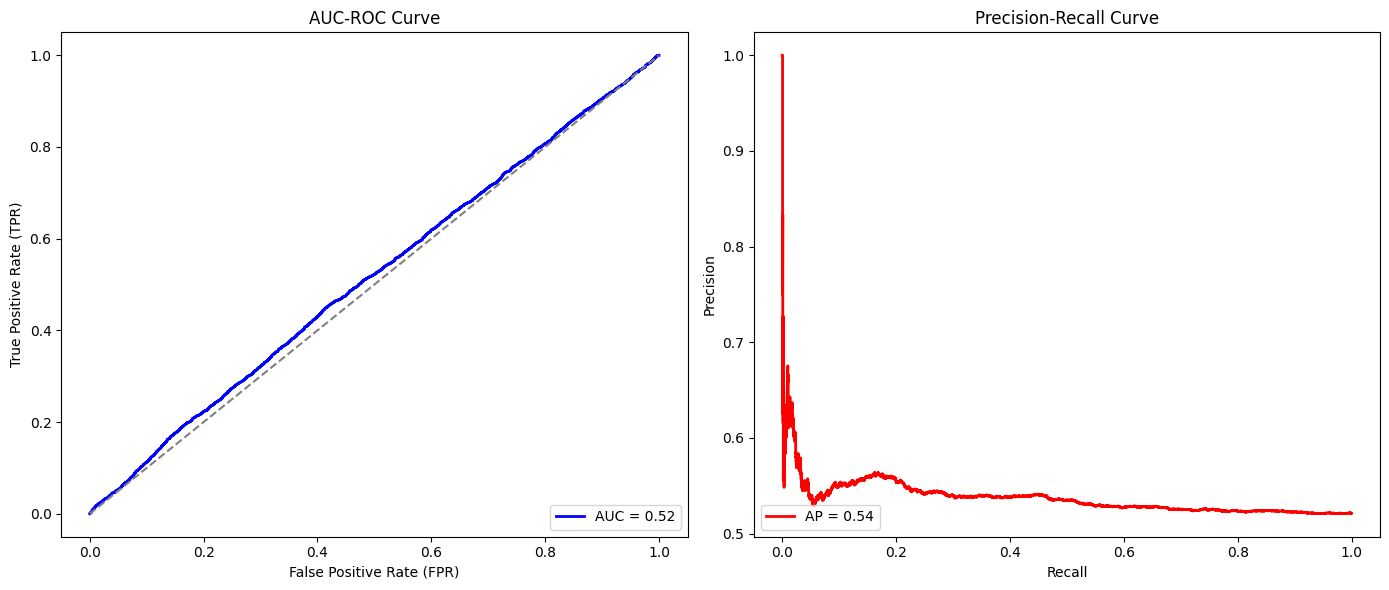

In [56]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get the predicted probabilities for the positive class
y_probs = log_reg.predict_proba(X_test)[:, 1]  # Probabilities for class '1' (buy)

# AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
average_precision = average_precision_score(y_test, y_probs)

# Plotting AUC-ROC curve
plt.figure(figsize=(14, 6))

# AUC-ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='red', lw=2, label=f'AP = {average_precision:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

# Show both curves
plt.tight_layout()
plt.show()

In [57]:
# Save the trained model
model_filename = 'artifacts/models/deep_learning_model.h5'
model.save(model_filename)
print(f"Model saved to {model_filename}")

Model saved to artifacts/models/deep_learning_model.h5
